## Testing on Refind Data

In [1]:
import time
from dotenv import load_dotenv

from typing import List, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END

from IPython.display import display, Markdown, Image


from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
)

import pandas as pd

from tqdm.notebook import tqdm

In [2]:
MODEL = "google_genai:gemini-2.5-flash-preview-05-20"  # 
MODEL_2 = "openai:gpt-4o"
MODEL_3 = "google_genai:gemini-2.0-flash-001"

In [3]:
model_dict = {
    "example_generator_model": MODEL_3,
    "classifier_model": MODEL_2
}

In [4]:
load_dotenv("../.env")

True

In [5]:
# os.environ["LANGCHAIN_PROJECT"] = "AgentXSyntheticNShotGemini_Semeval_task8"
# os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"

In [ ]:
df = pd.read_csv("../datasets/core_data/test_core.csv")
print(df.shape)
df.head()

(708, 5)


,relation,invert_relation,e1_name,e2_name,context
0,undefined,0,"Winnie, Inc.",Android,The Winnie iPhone app was launched in June 201...
1,product_or_service_of,1,Marker International,Duplex,Hannes Marker felt he could improve on the con...
2,shareholder_of,1,Stone & Wood Brewing Co.,Lion,"In 2012 Cook , Rogers and Jurisich bought back..."
3,collaboration,0,Bell Canada,"Cellport Systems, Inc.",In 1994 a consortium of six cellular carriers ...
4,subsidiary_of,1,Global Electronic Trading Company,GETCO,The firm 's primary business is electronic mar...


In [21]:
all_relations = df['relation'].unique().tolist()
print(all_relations)

['no_relation', 'agreement_with', 'shares_of', 'acquired_by', 'subsidiary_of', 'attended', 'employee_of', 'member_of', 'title', 'formed_in', 'headquartered_in', 'operations_in', 'revenue_of', 'profit_of', 'loss_of', 'cost_of', 'formed_on', 'acquired_on', 'founder_of']


In [22]:
# structured output Data Models
class SelectedLabels(BaseModel):
    labels: List["str"]  # add something to limit number of selected labels, check later

class GeneratedPositiveExample(BaseModel):
    context: str
    entity_1: str
    entity_2: str
    predicted_label: Literal[*all_relations]
    explanation: str

class GeneratedPositiveExamples(BaseModel):
    examples: List[GeneratedPositiveExample]

class GeneratedNegativeExample(BaseModel):
    context: str
    entity_1: str
    entity_2: str
    predicted_label: str = Field(description="Incorrectly Predicted label")
    explanation : str = Field(description="Explanation why predicted label is not correct")
    correct_label : str = Field(description="Correct label")

class GeneratedNegativeExamples(BaseModel):
    examples: List[GeneratedNegativeExample]

class EvaluateRelationshipOutput(BaseModel):
    output: Literal[*all_relations]
    explanation: str = Field(default="Explanation for choosing the label")

In [8]:
# state for input
class InputState(TypedDict):
    context : str
    entity_1 : str
    entity_2 : str
    list_of_labels : List[str]
    selected_labels : SelectedLabels 
    negative_examples : List
    positive_examples : List
    # max_num_of_revisions : int
    label : str
    explanation : str

In [9]:
label_direction_related_info = "Consider Entity 1 to be the head entity and Entity 2 to be the tail entity. "

In [ ]:
def select_helpful_labels_for_n_shot(state: InputState):
    llm = init_chat_model(
        model=model_dict["classifier_model"],
        temperature=0.2
    ).with_structured_output(SelectedLabels)

    out = llm.invoke(
        [
            SystemMessage(
                content=f"You are a helpful assistant. You will be given a text with entities and a list of labels. Select labels from the list of labels. Selected labels should be such that generated positive and negative examples using these labels will be useful in doing N Shot Classification. {label_direction_related_info} In short, the model will be able to get confused between these selected labels while answering. Provide the output in a JSON format."
            ),
            HumanMessage(
                content=f"Labels: {state['list_of_labels']}\nContext: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}"
            )
        ]
    )
    return {
        "selected_labels": out.labels
    }

def generate_positive_example(state: InputState):
    """Generate a positive example for the given text, entities and label."""
    positive_example_llm = init_chat_model(
        model=model_dict["example_generator_model"],
        temperature=0.4,
    ).with_structured_output(GeneratedPositiveExamples)

    out = positive_example_llm.invoke(
        [
            SystemMessage(
                content=f"You are a helpful assistant that generates examples for relationship classification task. You will be given a text with entities and a list of labels. Generate distinct helpful and informative positive examples with similar context and entities. Do not use exact context or entities in generated examples. Generate an example for each label. {label_direction_related_info} Provide the output in a JSON format."
            ),
            HumanMessage(
                content=f"Labels: {state['selected_labels']}\nContext: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}"
            )
        ]
    )
    out = out.model_dump()
    return {
        "positive_examples": out["examples"]
    }


def generate_negative_example(state: InputState):
    """Generate a negative example for the given text, entities and label."""
    negative_example_llm = init_chat_model(
        model=model_dict["example_generator_model"],
        temperature=0.4,
    ).with_structured_output(GeneratedNegativeExamples)

    out = negative_example_llm.invoke(
        [
            SystemMessage(
                content=f"You are a evil assistant that generates examples for relationship classification task. You will be given a text with entities and a list of labels. Generate distinct helful and informative negative examples with similar context and entities. Do not use the exact context or entities in generated examples. Generate an example for each label. The generated examples should be such that they could fool a naive classifier. {label_direction_related_info} Provide the output in a JSON format."
            ),
            HumanMessage(
                content=f"Labels: {state['selected_labels']}\nContext: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}"
            )
        ]
    )
    out = out.model_dump()
    
    return {
        "negative_examples": out["examples"]
    }

In [23]:
def format_positive_examples(positive_examples):
        prompt = "Positive Examples:\n"
        for i, ex in enumerate(positive_examples, 1):
            prompt += (
                f"Example {i}:\n"
                f"  Context: {ex['context']}\n"
                f"  Entity 1: {ex['entity_1']}\n"
                f"  Entity 2: {ex['entity_2']}\n"
                f"  Predicted Label: {ex['predicted_label']}\n"
                f"  Explanation: {ex['explanation']}\n\n"
            )
        return prompt

def format_negative_examples(negative_examples):
    prompt = "Negative Examples:\n"
    for i, ex in enumerate(negative_examples, 1):
        prompt += (
            f"Example {i}:\n"
            f"  Context: {ex['context']}\n"
            f"  Entity 1: {ex['entity_1']}\n"
            f"  Entity 2: {ex['entity_2']}\n"
            f"  Predicted Label: {ex['predicted_label']}\n"
            f"  Explanation: {ex['explanation']}\n"
            f" Correct Label: {ex['correct_label']}\n\n"
        )
    return prompt


def evaluate_relationship(state: InputState):
    """Evaluate the relationship between the head and tail entities in the text."""
    relationship_evaluator = init_chat_model(
        model=model_dict["classifier_model"],
        temperature=0,
    ).with_structured_output(EvaluateRelationshipOutput)
    
    postive_examples_string = format_positive_examples(state['positive_examples'])
    negative_examples_string = format_negative_examples(state['negative_examples'])
    
    out = relationship_evaluator.invoke(
        [
            SystemMessage(
                content=f"You are a helpful assistant that identifies the relationship between two entities given a context. You will be given a context, and a pair of entities and a list of possible labels. You will also be given positive examples and negative examples for each similar labels for better understanding. Provide the answer in a JSON format. The output should be the label that best describes the relationship between the entities in the context. {label_direction_related_info}"
            ),
            HumanMessage(
                content=f"List of Labels: \n {state['list_of_labels']} \n\n{postive_examples_string} {negative_examples_string} Context: {state['context']}\n Entity 1: {state['entity_1']}\n Entity 2: {state['entity_2']}"
            ),
        ]
    )
    
    return {
        "label": out.output,
        "explanation": out.explanation
    }


# def to_revise_or_not(state: InputState):
#     """Decide whether to revise the generated examples or not."""
#     if state["max_num_of_revisions"] <= 0:
#         return "revision_limit_reached"
    
#     llm = init_chat_model(
#         model="openai:gpt-4o-mini",
#         temperature=0,
#     )

#     out = llm.invoke(
#         [
#             SystemMessage(
#                 content="You are a helpful assistant that decides whether to revise the generated examples or not. You will be given a context, head entity, tail entity, predicted label. You will also be given positive examples and negative examples that were used to get the predicted label. Decide whether the predicted label is correct or not. Provide the answer in a JSON format."
#             ),
#             HumanMessage(
#                 content=f"List of Labels: \n {state['list_of_labels']} \n\n Positive Examples : \n{state['positive_examples']}\n\n Negative Examples:\n {state['negative_examples']}\n\n Context: {state['context']}\n Head Entity: {state['head_entity']}\n Tail Entity: {state['tail_entity']}"
#             ),
#         ]
#     )
    
#     return {
#         "max_num_of_revisions": state["max_num_of_revisions"] + 1
#     }

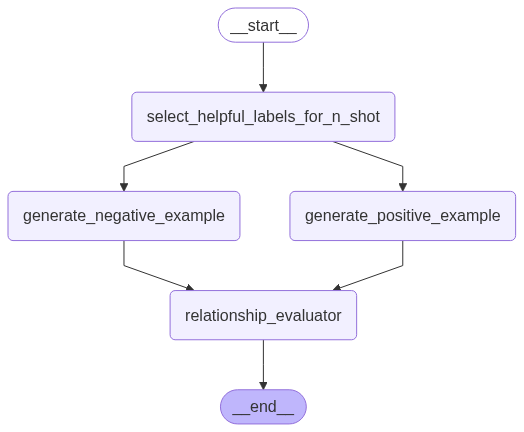

In [24]:
graph_builder = StateGraph(InputState)

graph_builder.add_node("select_helpful_labels_for_n_shot", select_helpful_labels_for_n_shot)
graph_builder.add_node("generate_positive_example", generate_positive_example)  
graph_builder.add_node("generate_negative_example", generate_negative_example)
graph_builder.add_node("relationship_evaluator", evaluate_relationship)

graph_builder.add_edge(START, "select_helpful_labels_for_n_shot")
graph_builder.add_edge("select_helpful_labels_for_n_shot", "generate_positive_example")
graph_builder.add_edge("select_helpful_labels_for_n_shot", "generate_negative_example")

graph_builder.add_edge(
    ["generate_positive_example", "generate_negative_example"],
    "relationship_evaluator",
)
graph_builder.add_edge("relationship_evaluator", END)

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
%%time
input_data = {
    "context": df.iloc[1]['sentence'],
    "entity_1":df.iloc[1]['head_entity_text'],
    "entity_2": df.iloc[1]['tail_entity_text'],
    "list_of_labels": all_relations,
}
result = graph.invoke(input_data)
result["label"]

CPU times: user 679 ms, sys: 201 ms, total: 880 ms
Wall time: 26.7 s


'no_relation'

In [14]:
answers = {}

In [ ]:
%%time
for row_id, row in tqdm(df.iterrows(), total=df.shape[0]):
    if row_id not in answers:
        text = row['sentence']
        entity_1 = row['head_entity_text']
        entity_2 = row['tail_entity_text']
        try : 
            input_data = {
                "context": text,
                "entity_1": entity_1,
                "entity_2": entity_2,
                "list_of_labels": all_relations,
            }
            
            result = graph.invoke(input_data)
            
            answers[row_id] = result["label"]
            time.sleep(2)
        except Exception as e:
            print(f"Error processing row {row_id}: {e}")

  0%|          | 0/4221 [00:00<?, ?it/s]


1. Name DynamicCOTGenAgent

In [22]:
len(answers)

583

In [49]:
df['predicted_label'] = df.index.map(answers)

In [51]:
df.isnull().sum()

head_entity_text    0
tail_entity_text    0
relation            0
sentence            0
predicted_label     1
dtype: int64

In [52]:
df = df.dropna(subset=['predicted_label'])

In [54]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(df.relation, df.predicted_label, labels=all_relations))

                  precision    recall  f1-score   support

     acquired_by       0.40      0.55      0.46        11
     acquired_on       0.95      0.79      0.86        24
  agreement_with       0.56      0.76      0.64        25
        attended       1.00      0.57      0.73         7
         cost_of       0.50      0.25      0.33         4
     employee_of       0.54      0.56      0.55        25
       formed_in       0.33      0.06      0.10        17
       formed_on       0.92      0.88      0.90        25
      founder_of       0.88      0.74      0.80        19
headquartered_in       0.71      0.80      0.75        25
         loss_of       0.96      0.92      0.94        25
       member_of       0.43      0.12      0.19        25
     no_relation       0.16      0.40      0.23        25
   operations_in       0.63      0.48      0.55        25
       profit_of       1.00      1.00      1.00         5
      revenue_of       0.88      0.92      0.90        25
       shares

In [58]:
f1_score(df.relation, df.predicted_label, average='micro')

0.6373056994818653